
# LAB: **IMAGE SEGMENTATION**



---

***STUDENTS:***

*Pablo Santa Cruz Sánchez - 100428988@alumnos.uc3m.es*

*Pablo Tomás Campos Fernández - 100406000@alumnos.uc3m.es*

*Laura Martínez Díaz - 100428953@alumnos.uc3m.es*

---


**Image segmentation** is a method in which a digital image is broken down into various subgroups called *Image segments* which helps in reducing the complexity of the image to make further processing or analysis of the image simpler. **Segmentation in easy words is assigning labels to pixels.** All picture elements or pixels belonging to the same category have a common label assigned to them. **For example**: Let’s take a problem where the picture has to be provided as input for object detection. Rather than processing the whole image, the detector can be inputted with a region selected by a segmentation algorithm. This will prevent the detector from processing the whole image thereby reducing inference time.
<figure>
<center><img src="https://vladlen.info/wp-content/uploads/FSO-1.jpg" width="60%"></center>
<figcaption align = "center"> Image segmentation example. </figcaption>
</figure>


# Approaches in Image Segmentation

*   *Similarity approach*: This approach is based on detecting similarity between image pixels to form a segment, based on a threshold. ML algorithms like clustering are based on this type of approach to segment an image.
*   *Discontinuity approach*: This approach relies on the discontinuity of pixel intensity values of the image. Line, Point, and Edge Detection techniques use this type of approach for obtaining intermediate segmentation results which can be later processed to obtain the final segmented image.

# Image Segmentation Techniques

*   Threshold Based Segmentation
*   Edge Based Segmentation
*   Region-Based Segmentation
*   Clustering Based Segmentation
*   **Artificial Neural Network Based Segmentation**

In this lab we will focus on **Artificial Neural Network Based Segmentation** using **U-Net architecture**.

# U-Net

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other **semantic segmentation tasks**.

U-Net builds on a previous architecture called the **Fully Convolutional Network (FCN)** which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that **the input size no longer needs to be fixed**, as it does when dense layers are used.

Unfortunately, **the final feature layer of the FCN suffers from information loss due to downsampling too much**. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough.

<figure>
<center><img src="https://miro.medium.com/max/640/1*NXNGhfSyzQcKzoOSt-Z0Ng.webp" width="60%"></center>
<figcaption align = "center"> FCN architecture. </figcaption>
</figure>


**U-Net improves on the FCN**. Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds **skip connections**, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

<figure>
<center><img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="70%"></center>
<figcaption align = "center"> U-Net architecture. </figcaption>
</figure>






# Dataset

In this lab we will use [**Cityscapes**](https://www.cityscapes-dataset.com/) **Image Pairs dataset**. It contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix](https://phillipi.github.io/pix2pix/) paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks.

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.



# Imports


In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

# PART I: Loading Cityscapes dataset

First, import to your own Drive the folder I shared with you in Aula Global.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# UPDATE THIS ACCORDING TO YOUR PATH!
path_to_folder = '/content/drive/MyDrive/Aprendizaje_profundo/Lab2/Cityscapes/cityscapes_data'

train_dir = os.path.join(path_to_folder, "train")
test_dir = os.path.join(path_to_folder, "val")

train_fns = os.listdir(train_dir)
test_fns = os.listdir(test_dir)

print('We have %d train images.' %len(train_fns))
print('We have %d test images.' %len(test_fns))


We have 2975 train images.
We have 500 test images.


Visualize one image from Cityscapes

/content/drive/MyDrive/Aprendizaje_profundo/Lab2/Cityscapes/cityscapes_data/train/2745.jpg


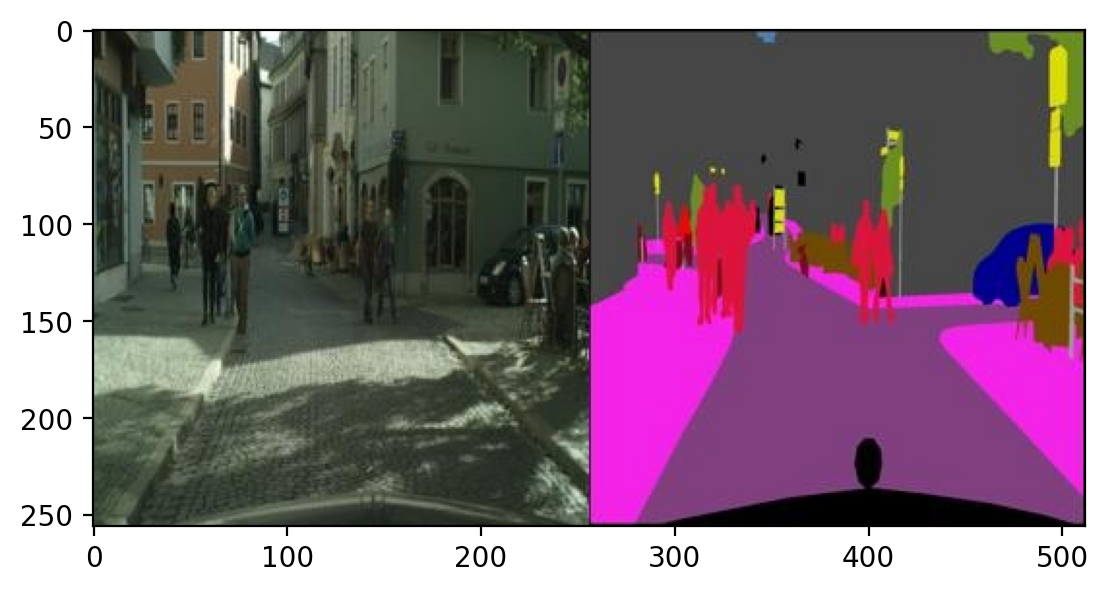

In [ ]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

# PART II: Extracting Image and Labels
The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [ ]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

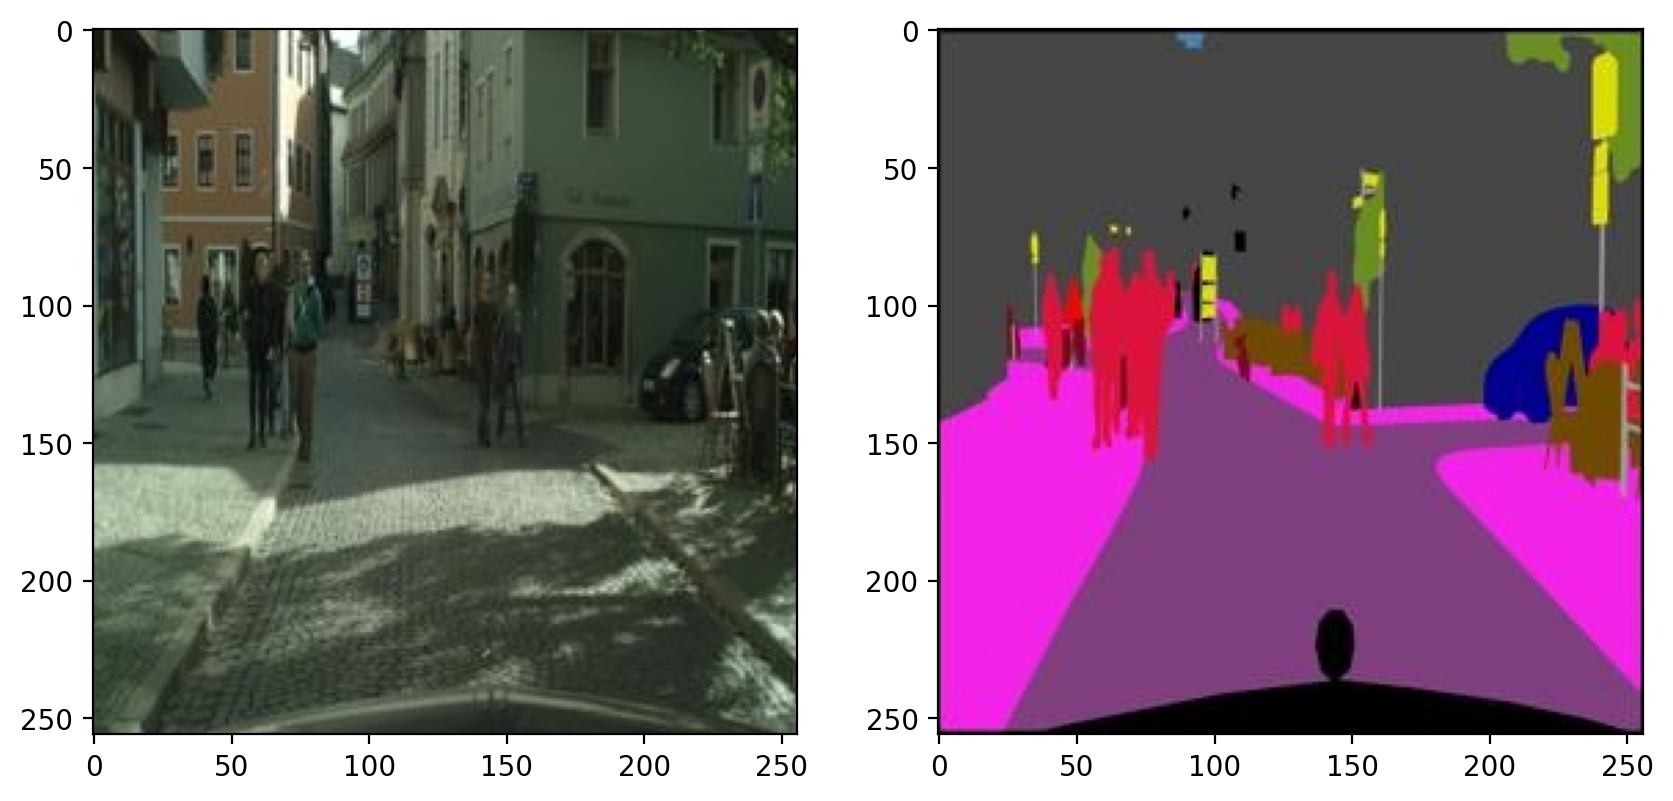

In [ ]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

We need to transform the RGB label image (3 channels) to a label matrix (1 channel). For this, we have two options:

1.   Define a dictionary that maps RGB values to class labels.
2.   Train a clustering model (as K-Means) to assign class labels to RGB values automatically.


Let's try the second option to spice up things a little!

> **Exercise**: Complete the following code.


In [ ]:
# Define random RGB images
num_items = 5000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(5000, 3)


In [ ]:
result = []

for file in train_fns[:10]:
  a, _ = split_image(np.array(Image.open(os.path.join(train_dir, file)).convert("RGB")))
  result.append(a)

In [ ]:
images = []
for train_fn in train_fns[:100]:
    sample_image_fp = os.path.join(train_dir, train_fn)
    sample_image = Image.open(sample_image_fp).convert("RGB")
    sample_image = np.array(sample_image)
    cityscape, label = split_image(sample_image)
    images.append((cityscape, label))

In [ ]:
flattened_images = np.concatenate([image.reshape(-1, 3) for image, _ in images], axis=0)

In [ ]:
# Learn how to cluster all the colors in num_classes
num_classes = 10
# Since we have to assign each pixel to its corresponding class, we run a KMeans model using as cluster number the number of classes
label_model = KMeans(n_clusters=10, random_state=42)
label_model.fit(flattened_images)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

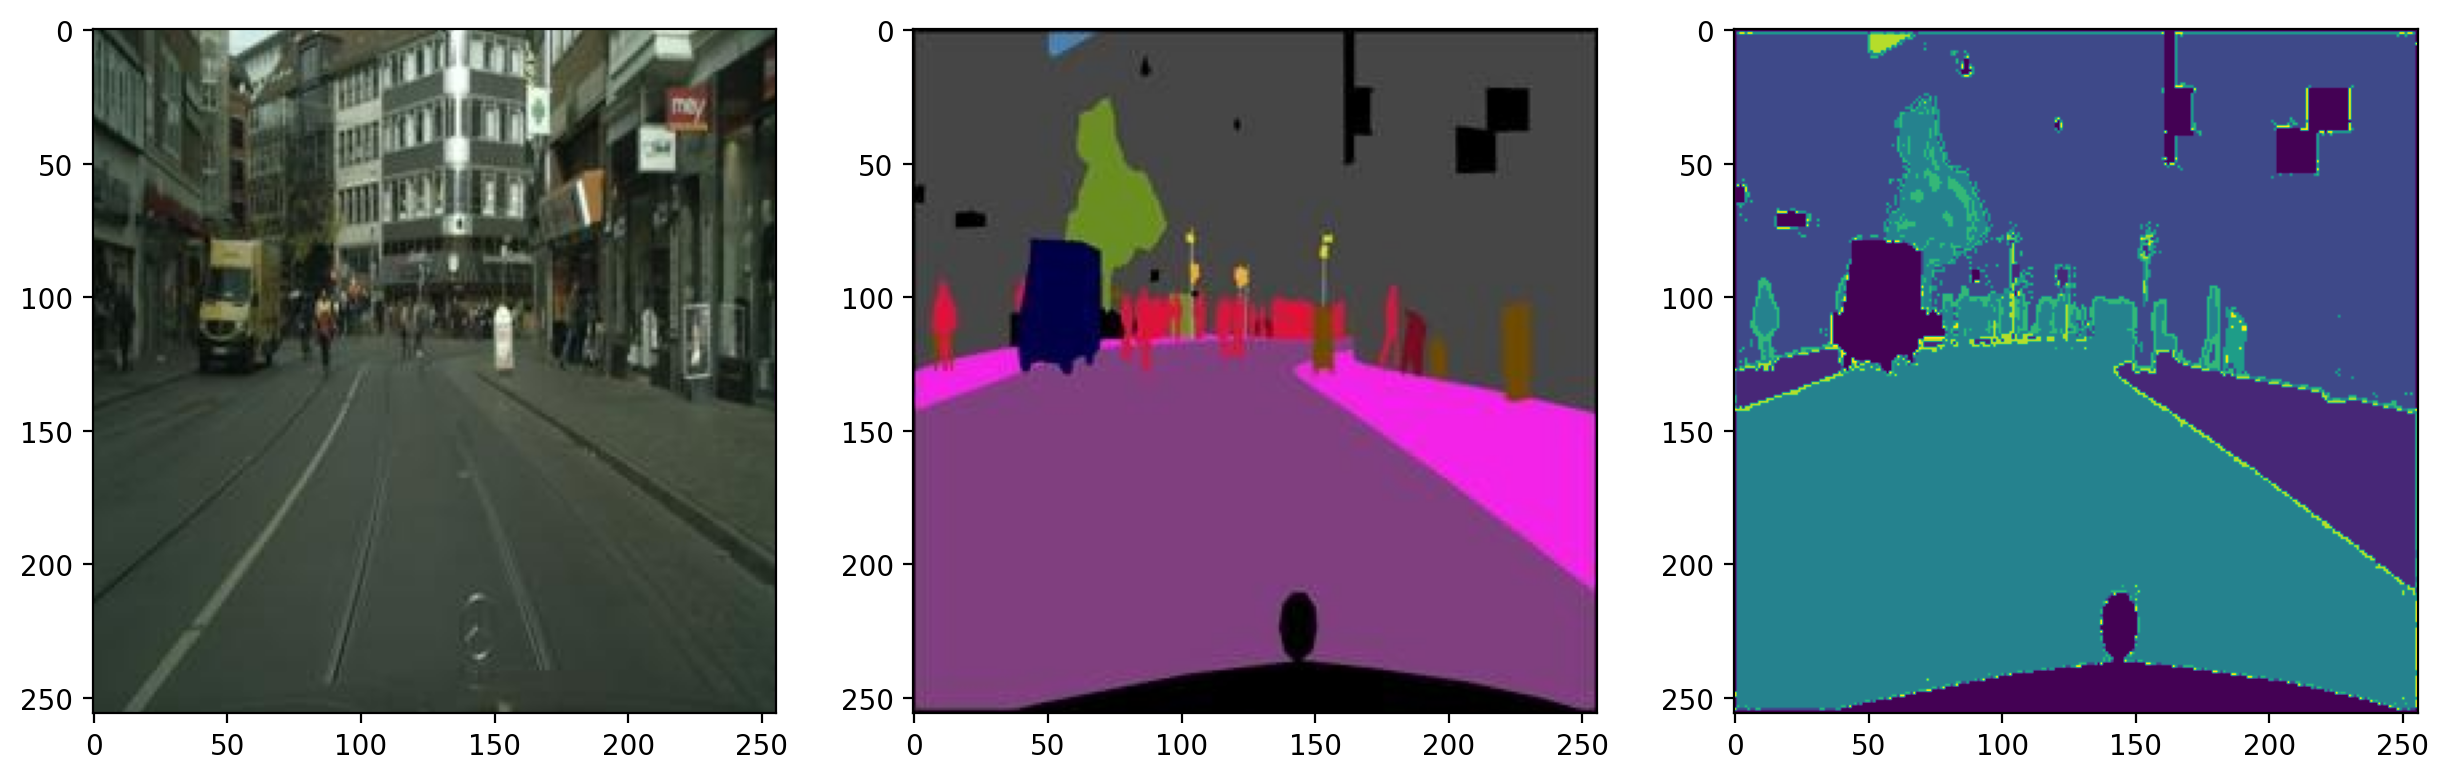

In [ ]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

Como se puede observar, el modelo KMeans segmenta de forma coherente las imágenes, asignando cada píxel a su clúster (clase) correspondiente de forma bastante precisa.

Now we define a Dataset for this data. In the transformations we reduce the size of the images to speed up training.

In [ ]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):

    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)

  def __getitem__(self, index):

    # Get the image from the root directory
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)

    # Split in image and labels
    cityscape, label = self.split_image(image)

    # Extract and transform label matrix
    label = np.array(self.transform_lab(Image.fromarray(label)))
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(64,64)
    label_class = torch.Tensor(label_class).long()

    # Transform image
    cityscape = self.transform_img(Image.fromarray(cityscape))

    return cityscape, label_class

  def split_image(self, image):

    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]

    return cityscape, label

  def transform_img(self, image):

    transform_ops = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((64, 64)),
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return transform_ops(image)

  def transform_lab(self, image):

    transform_ops = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((64, 64))
    ])

    return transform_ops(image)

> **Exercise**: complete the following code to create a dataset for training data and another one for test data. Show an example (image and its segmentation) from the train dataset.

In [ ]:
dataset_train = CityscapeDataset(train_dir, label_model ) # YOUR CODE HERE
dataset_test = CityscapeDataset(test_dir, label_model)# YOUR CODE HERE

Let's show an example from our defined dataset. We define a method to visualize the images, as they are normalized.

In [ ]:
def img_show(img):
    img = img / 2 + 0.5     # unnormalize to plot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


One we have defined the Dataset, we can define train and test dataloaders!

In [ ]:
batch_size = 32
valid_size = 500

# Training partition
part_tr = torch.utils.data.random_split(dataset_train, [len(dataset_train)-valid_size, valid_size])[0]
# Use sampler for randomization
training_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_tr)))
# Define the dataloader
trainloader = torch.utils.data.DataLoader(part_tr, batch_size=batch_size, sampler=training_sampler)

# Validation partition
part_val = torch.utils.data.random_split(dataset_train, [valid_size, len(dataset_train)-valid_size])[0]
# Use sampler for randomization
valid_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_val)))
# Define the dataloader
validloader = torch.utils.data.DataLoader(part_val, batch_size=batch_size, sampler=valid_sampler)

# Test partition
# Use sampler for randomization
test_sampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_test)))
# Define the dataloader
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, sampler=test_sampler)


In [ ]:
print('TRAIN: ', len(part_tr))
print('VALIDATION: ', len(part_val))
print('TEST: ', len(dataset_test))


TRAIN:  2475
VALIDATION:  500
TEST:  500


# PART III: Define the model

In this lab we are reproducing the following architecture, but for color images (we have a 3 channel image as input).

<figure>
<center><img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="70%"></center>
<figcaption align = "center"> U-Net architecture. </figcaption>
</figure>


This architecture has 4 main blocks:

*   **Encoder**: The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3×3 convolutions (padding=1, stride=1), each followed by a rectified linear unit (ReLU) and a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.
*   **Bottleneck**: Mid layer that passes the compressed information from the encoder to the decoder.
*   **Decoder**: Every step in the expansive path consists of an upsampling of the feature map followed by a 2×2 convolution (“up-convolution”) (stride = 2, padding = 0) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3×3 convolutions, each followed by a ReLU.
*   **Classifier**: Final convolution layer that outputs the segmented image.

The original U-Net does not use batch normalization in between the convolution layer and ReLU. Here we insert batch normalization in between them. It helps the network to reduce internal covariance shift and makes the network more stable while training.



# Basic blocks
First we implement the basic blocks for this architecture. The first one is the **convolutional block**, which consists of two 3x3 convolutional layers (padding=1, stride=1), each one followed by batch normalization and ReLU activation.

> **Exercise**: complete the following code.

In [ ]:
# === CONVOLUTIONAL BLOCK === #
# Two 3x3 convolutional layers, each followed by a batch
# normalization and a ReLU activation.

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels= in_c, out_channels=out_c,kernel_size=3, padding=1, stride=1)# YOUR CODE HERE
        self.bn1 = nn.BatchNorm2d(out_c)# YOUR CODE HERE

        self.conv2 = nn.Conv2d(in_channels= out_c, out_channels=out_c,kernel_size=3, padding=1, stride=1)# YOUR CODE HERE
        self.bn2 = nn.BatchNorm2d(out_c)# YOUR CODE HERE

        self.relu = nn.ReLU()

    def forward(self, inputs):

        # YOUR CODE HERE
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

Now we define the **encoder block**, which consists of a convolutional block followed by a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.

Note that this block should return the output before and after the downsampling, so we can esily implement the skip connections in the full architecture.

> **Exercise**: complete the following code.

In [ ]:
# === ENCODER BLOCK === #
# It consists of an conv_block followed by a max pooling.
# Here the number of filters doubles and the height and width half after every block.

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)# YOUR CODE HERE
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)# YOUR CODE HERE

    def forward(self, inputs):

        # YOUR CODE HERE
        x = self.conv.forward(inputs)
        p = self.pool(x)

        return x, p

The last basic block we need to implement is the decoder block, which consists of a a 2×2 transpose convolution (“up-convolution”) (stride = 2, padding = 0) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path (**skip connections!**), and a convolutional block.

> **Exercise**: complete the following code.

In [ ]:
# === DECODER BLOCK === #
# The decoder block begins with a transpose convolution, followed by a concatenation with the skip
# connection from the encoder block. Next comes the conv_block.
# Here the number filters decreases by half and the height and width doubles.

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels=in_c, out_channels=out_c, kernel_size=2, stride=2, padding=0)# YOUR CODE HERE
        self.conv = conv_block(in_c, out_c)# YOUR CODE HERE

    def forward(self, inputs, skip):
        x = self.up.forward(inputs) # YOUR CODE HERE
        x = torch.cat([x, skip], axis=1)
        x = self.conv.forward(x)# YOUR CODE HERE

        return x

# Full architecture

Now that we have implemented all the basic blocks, we can build our **full U-Net architecture**!

> **Exercise**: complete the following code.

In [ ]:
# === FULL ARCHITECTURE === #

class UNet(nn.Module):
    def __init__(self, n_labels):
        super().__init__()

        # ENCODER #
        # in_channels = 3, out_channels=64 for the first block
        self.e1 = encoder_block(3,64)# YOUR CODE HERE
        self.e2 = encoder_block(64,128)# YOUR CODE HERE
        self.e3 = encoder_block(128,256)# YOUR CODE HERE
        self.e4 = encoder_block(256,512)# YOUR CODE HERE

        # BOTTLENECK #
        self.b = conv_block(512, 1024)

        # DECODER #
        self.d1 = decoder_block(1024,512)# YOUR CODE HERE
        self.d2 = decoder_block(512,256)# YOUR CODE HERE
        self.d3 = decoder_block(256,128)# YOUR CODE HERE
        self.d4 = decoder_block(128,64)# YOUR CODE HERE

        # CLASSIFIER #
        self.outputs = nn.Conv2d(64, n_labels, kernel_size=1, padding=0)

    def forward(self, inputs):

        # NOTATION:
        # s -> skip
        # p -> pooling

        # ENCODER #
        s1, p1 = self.e1.forward(inputs)# YOUR CODE HERE
        s2, p2 = self.e2.forward(p1)# YOUR CODE HERE
        s3, p3 = self.e3.forward(p2)# YOUR CODE HERE
        s4, p4 = self.e4.forward(p3)# YOUR CODE HERE

        # BOTTLENECK #
        b = self.b.forward(p4)# YOUR CODE HERE

        # DECODER #
        d1 = self.d1.forward(b,s4)# YOUR CODE HERE
        d2 = self.d2.forward(d1,s3)# YOUR CODE HERE
        d3 = self.d3.forward(d2,s2)# YOUR CODE HERE
        d4 = self.d4.forward(d3,s1)# YOUR CODE HERE

        # CLASSIFIER #
        outputs = self.outputs(d4)

        return outputs

The following class completes the implementation of the U-Net, extending it with a training method.

> **Exercise**: complete the following code.

In [ ]:
class UNet_extended(UNet):

    def __init__(self, n_labels, lr=1e-3,epochs=20):

        super().__init__(n_labels)

        # TRAINING VARIABLES
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        # CRITERION
        self.criterion = nn.CrossEntropyLoss()# YOUR CODE HERE

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self, trainloader, validloader):

        self.train()

        for e in range(int(self.epochs)):

          running_loss = 0.

          for images, labels in tqdm(trainloader, desc=f"Epoch {e+1}/{self.epochs}"):

            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optim.zero_grad()

            pred = self.forward(images)# YOUR CODE HERE

            loss = self.criterion(pred, labels)# YOUR CODE HERE

            loss.backward()

            self.optim.step()

            running_loss += loss.item()

          self.loss_during_training.append(running_loss/len(trainloader))

          # Validation
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():

              running_loss = 0.

              for images,labels in validloader:

                  images = images.to(self.device)
                  labels = labels.to(self.device)

                  pred = self.forward(images)# YOUR CODE HERE

                  loss = self.criterion(pred,labels)# YOUR CODE HERE

                  running_loss += loss.item()

              self.valid_loss_during_training.append(running_loss/len(validloader))

          print('\nTrain Epoch: {} -> Training Loss: {:.6f}'.format(e,self.loss_during_training[-1]))
          print('Train Epoch: {} -> Validation Loss: {:.6f}'.format(e,self.valid_loss_during_training[-1]))

    def eval_performance(self,dataloader):

        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
                pred = self.forward(images)
                probs = nn.Softmax2d()(pred)# YOUR CODE HERE

                labels_pred = torch.argmax(probs, dim=1)
                equals = (labels_pred == labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(dataloader)

> **Exercise**: Train the model for 30 epochs. Plot the evolution of train and validation losses. Is the network overfitting?



Epoch 1/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 0 -> Training Loss: 1.205253
Train Epoch: 0 -> Validation Loss: 0.920430


Epoch 2/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 1 -> Training Loss: 0.897537
Train Epoch: 1 -> Validation Loss: 0.832584


Epoch 3/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 2 -> Training Loss: 0.822011
Train Epoch: 2 -> Validation Loss: 0.793739


Epoch 4/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 3 -> Training Loss: 0.773052
Train Epoch: 3 -> Validation Loss: 0.740960


Epoch 5/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 4 -> Training Loss: 0.730453
Train Epoch: 4 -> Validation Loss: 0.725331


Epoch 6/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 5 -> Training Loss: 0.699626
Train Epoch: 5 -> Validation Loss: 0.687659


Epoch 7/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 6 -> Training Loss: 0.680435
Train Epoch: 6 -> Validation Loss: 0.664916


Epoch 8/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 7 -> Training Loss: 0.662433
Train Epoch: 7 -> Validation Loss: 0.649539


Epoch 9/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 8 -> Training Loss: 0.648598
Train Epoch: 8 -> Validation Loss: 0.642300


Epoch 10/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 9 -> Training Loss: 0.634870
Train Epoch: 9 -> Validation Loss: 0.615594


Epoch 11/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 10 -> Training Loss: 0.612449
Train Epoch: 10 -> Validation Loss: 0.593299


Epoch 12/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 11 -> Training Loss: 0.608665
Train Epoch: 11 -> Validation Loss: 0.601174


Epoch 13/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 12 -> Training Loss: 0.598902
Train Epoch: 12 -> Validation Loss: 0.582575


Epoch 14/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 13 -> Training Loss: 0.588214
Train Epoch: 13 -> Validation Loss: 0.575527


Epoch 15/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 14 -> Training Loss: 0.570772
Train Epoch: 14 -> Validation Loss: 0.576273


Epoch 16/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 15 -> Training Loss: 0.570468
Train Epoch: 15 -> Validation Loss: 0.571987


Epoch 17/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 16 -> Training Loss: 0.568529
Train Epoch: 16 -> Validation Loss: 0.550214


Epoch 18/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 17 -> Training Loss: 0.541317
Train Epoch: 17 -> Validation Loss: 0.552490


Epoch 19/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 18 -> Training Loss: 0.536753
Train Epoch: 18 -> Validation Loss: 0.531056


Epoch 20/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 19 -> Training Loss: 0.520754
Train Epoch: 19 -> Validation Loss: 0.529962


Epoch 21/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 20 -> Training Loss: 0.519911
Train Epoch: 20 -> Validation Loss: 0.523994


Epoch 22/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 21 -> Training Loss: 0.518508
Train Epoch: 21 -> Validation Loss: 0.540405


Epoch 23/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 22 -> Training Loss: 0.522476
Train Epoch: 22 -> Validation Loss: 0.522105


Epoch 24/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 23 -> Training Loss: 0.495791
Train Epoch: 23 -> Validation Loss: 0.496636


Epoch 25/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 24 -> Training Loss: 0.481384
Train Epoch: 24 -> Validation Loss: 0.513787


Epoch 26/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 25 -> Training Loss: 0.505230
Train Epoch: 25 -> Validation Loss: 0.503076


Epoch 27/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 26 -> Training Loss: 0.479841
Train Epoch: 26 -> Validation Loss: 0.509547


Epoch 28/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 27 -> Training Loss: 0.473476
Train Epoch: 27 -> Validation Loss: 0.479642


Epoch 29/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 28 -> Training Loss: 0.461825
Train Epoch: 28 -> Validation Loss: 0.486991


Epoch 30/30:   0%|          | 0/78 [00:00<?, ?it/s]


Train Epoch: 29 -> Training Loss: 0.453757
Train Epoch: 29 -> Validation Loss: 0.469009


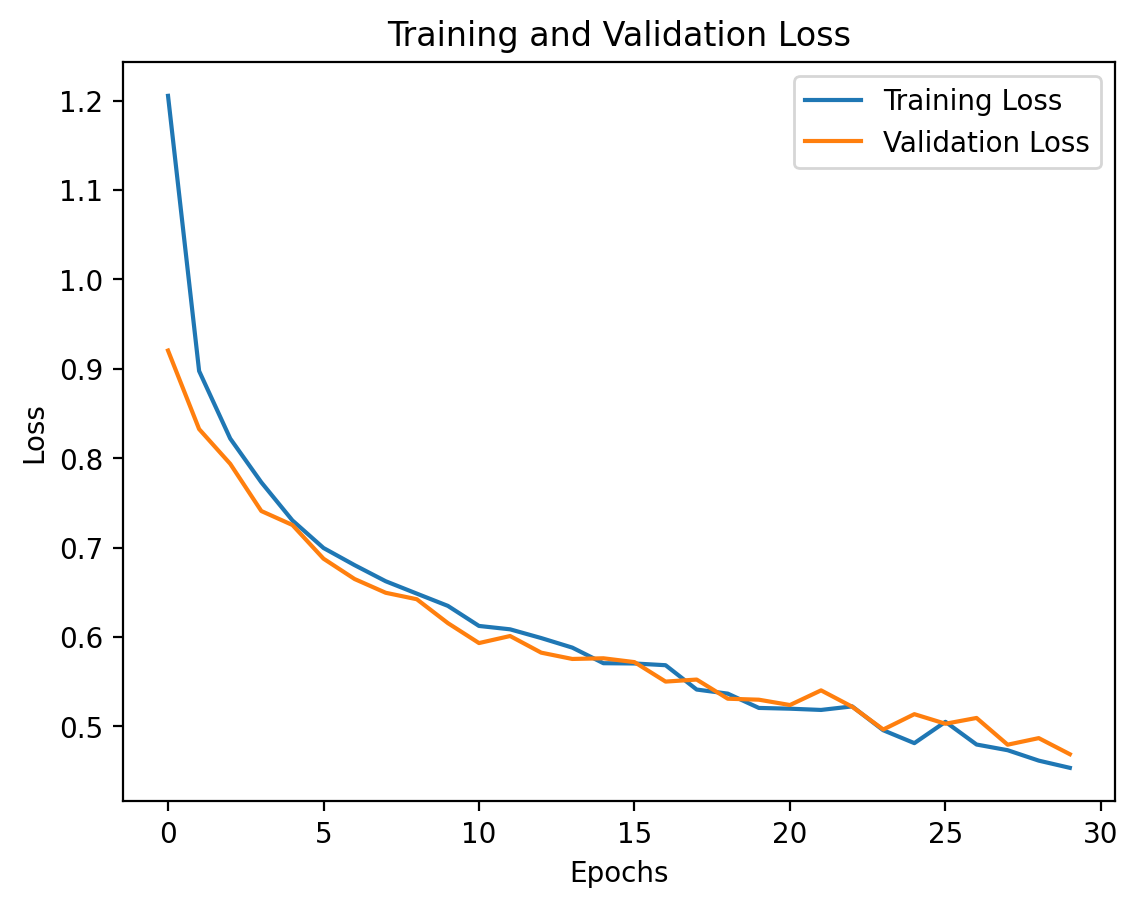

In [ ]:
n_epochs = 30
unet = UNet_extended(10, epochs=n_epochs)
unet.trainloop(trainloader,validloader)

epochs = range(0, n_epochs)
plt.plot(epochs, unet.loss_during_training, label='Training Loss')
plt.plot(epochs, unet.valid_loss_during_training, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

> **Exercise**: Evaluate the performance of the model in the different data partitions.

In [ ]:
# YOUR CODE HERE
performance = unet.eval_performance(testloader)
print(performance)

tensor(0.7896)


En la gráfica anterior, es posible observar cómo, por medio de entrenamiento, el modelo es capaz de reducir el valor del error de entrenamiento (CrossEntropyLoss) desde 1.2 hasta 0.45, y el error de validación desde 0.92 hasta 0.47.

También es sencillo determinar que no se ha producido un sobreajuste sobre el conjunto de entrenamiento, ya que los valores de error de ambos conjuntos son muy similares y el de validación en ningún momento incrementa. Adicionalmente, se considera que, con más épocas, el error podría seguir disminuyendo ya que a simple vista parece que la gráfica aún no ha llegado a converger completamente (dado que la cola de la curva no ha alcanzado aún una tendencia horizontal).

Se puede observar que, al inicio del entrenamiento, el error de validación es inferior que el de entrenamiento. Esto se considera un hecho fortuito debido a la aleatoriedad intrínseca sobre la generación de los conjuntos de datos. Conforme avanza el entrenamiento, los errores de ambos conjuntos van tomando valores más realistas y razonables.

Por último, se obtiene un valor de precisión de 0.7896 en el conjunto de test, o lo que es lo mismo, se acierta en la predicción de las clases del 78.96% de los píxeles. Este valor se considera dentro de lo razonable teniendo en cuenta el tamaño del conjunto de entrenamiento y las épocas de entrenamiento aplicadas

> **Exercise**: complete the following code to visualize a prediction. Discuss the obtained results.




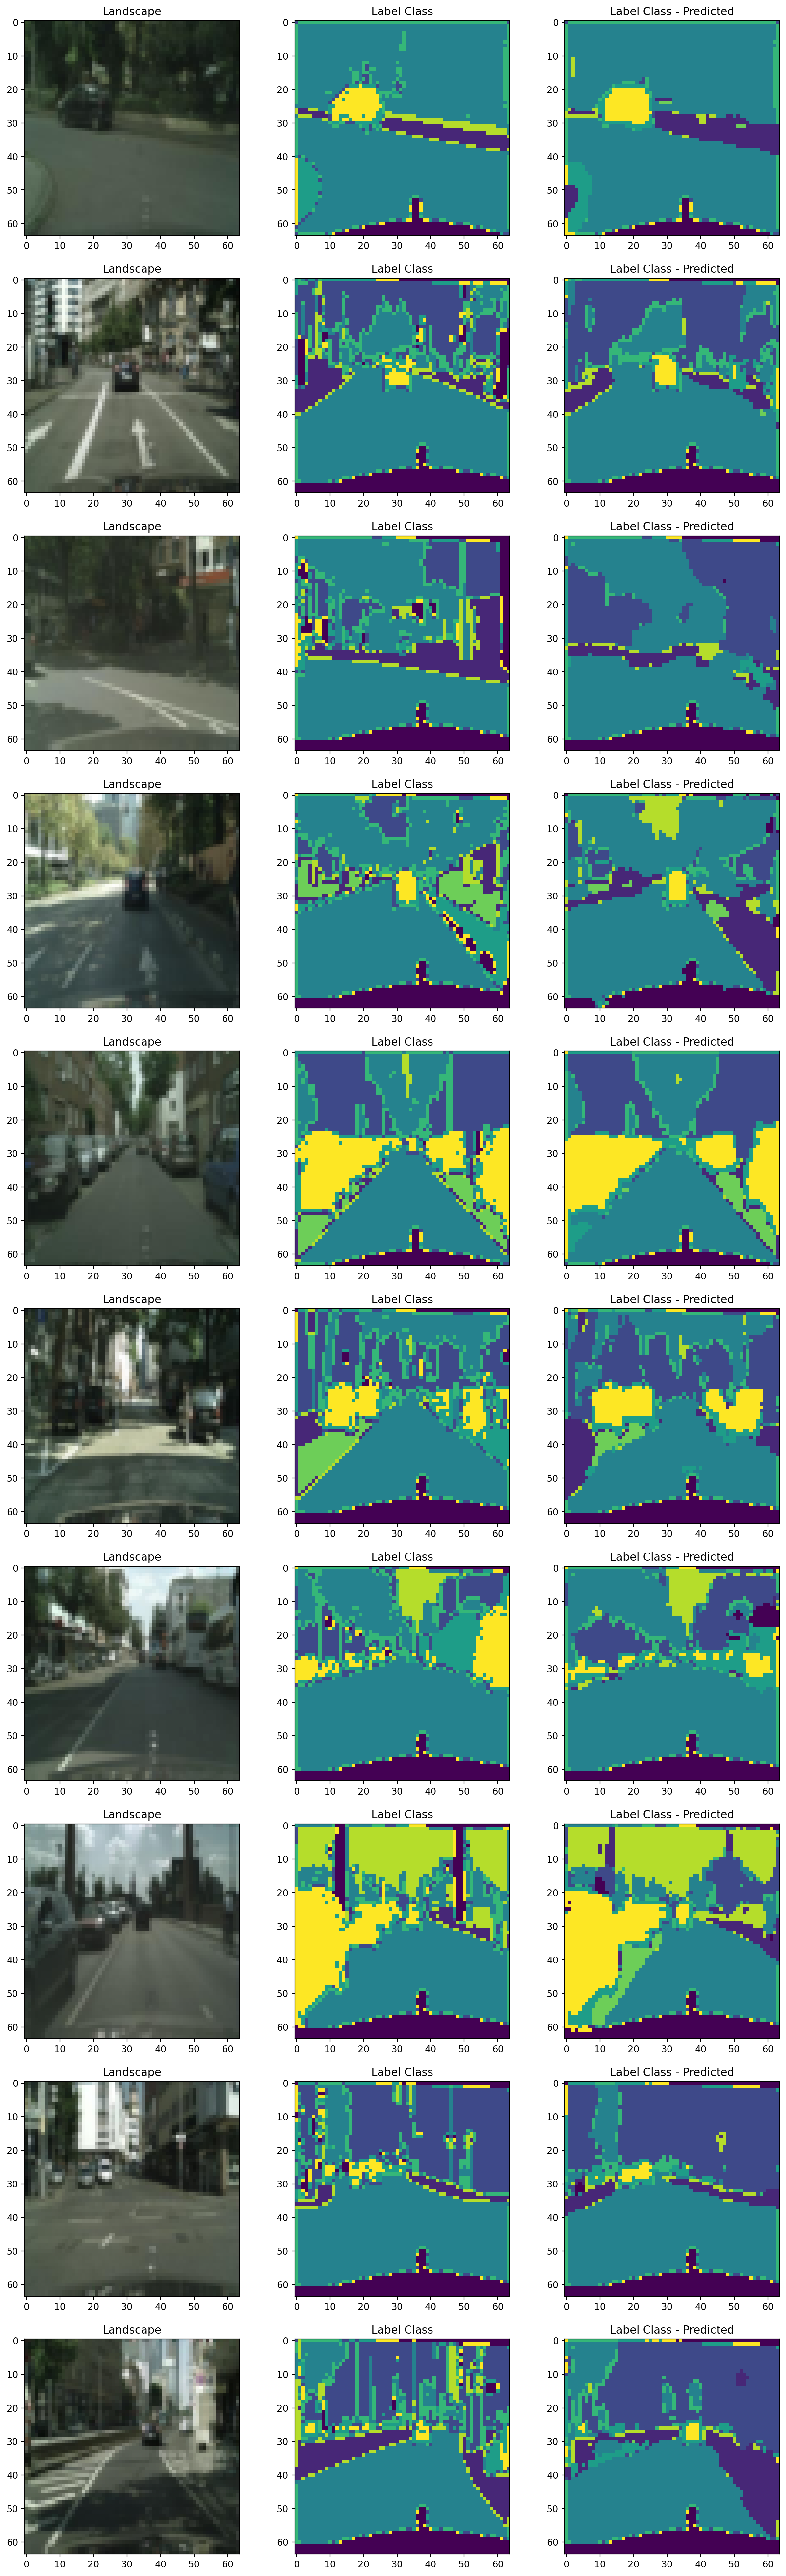

In [ ]:
img, labels = next(iter(testloader))
img, labels = img.to(unet.device), labels.to(unet.device)

probs = unet.forward(img)

labels_pred = torch.argmax(probs.cpu().detach(), dim=1)

fig, axes = plt.subplots(10, 3, figsize=(3*5, 10*5))

for i in range(10):
    img_plot = np.transpose(img[i,:,:,:].cpu().detach().numpy(), (1, 2, 0))
    img_plot = img_plot / 2 + 0.5
    axes[i, 0].imshow(img_plot)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(labels[i].cpu().detach().numpy())
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(labels_pred[i].cpu().detach().numpy())
    axes[i, 2].set_title("Label Class - Predicted")


Los resultados obtenidos son, en general, bastante satisfactorios. En concreto, el algoritmo es bastante capaz de segmentar la carretera, y los coches que hay en ella. Sin embargo, en cuanto a los detalles del entorno, el modelo comete algunos errores en su predicción. Por ejemplo, en la última predicción, los árboles y detalles que sí que salen en la label class no aparecen en la predicción del modelo. Dependiendo del uso que se quiera hacer de la herramienta, esto no supone demasiado problema, ya que los elementos principales como la carretera y los coches los detecta correctamente.

Para la predicción, también podría resultar de utilidad tener una mayor resolución de las imágenes que están siendo procesadas, ya que incluso para el ojo humano, algunos elementos son bastante difíciles de distinguir.

En general, el algoritmo consigue realizar la tarea de segmentación de manera bastante correcta y razonable, aunque siempre existe margen de mejora.